# Join data for Shots

* Group json files by repetitions
* Extract error and runs data
* Average this data
* Save in a new json file

In [1]:
from os import walk
import json
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.metrics import mean_squared_error


optimizers = ["gradient_descent", "spsa", "adam", "demon_adam"]
train_types= ['vqe','meta', 'opt_meta']

with open('./h2_fci.json', 'r') as reader:
    # Read & print the entire file
    data = reader.read()
    fci_h2 = json.loads(data)  

fci_energies = fci_h2["energies"]


f = []
for (dirpath, dirnames, filenames) in walk('./'):
    f.extend(filenames)
    break

print(len(f))

19


In [2]:
# Ordered by pairs - fd,ps
# main_groups = [ "simplified2design_3layers_fd", "simplified2design_3layers_ps", "simplified2design_4layers_fd", "simplified2design_4layers_ps", "meta_single_doubles_fd", "meta_single_doubles_ps", "meta_doubles_fd", "meta_doubles_ps", "kupccgsd_1layers_fd", "kupccgsd_1layers_ps", ]

main_groups = [ "meta_single_doubles_fd", "meta_single_doubles_ps", "meta_doubles_fd", "meta_doubles_ps" ]

In [3]:
condensed_data = []

for group_count,file_name_base in enumerate(main_groups):
    this_group = []
    files_in_group = [f_name for f_name in f if file_name_base in f_name]
    for file_name in files_in_group:
        with open(f'./{file_name}', 'r') as reader:
            # Read & print the entire file
            data = reader.read()
            this_group.append(json.loads(data))    
    
    group_dict = {i:{"errors":[0.0 for _ in train_types], "runs":[ 0 for _ in train_types]} for i in optimizers}
    for opt in optimizers:
        for data_entry in this_group:
            for count, result_type in enumerate(train_types):
                if result_type == 'meta':
                    group_dict[opt]["runs"][count] += data_entry['results'][opt][result_type]['runs']/len(this_group)
                    group_dict[opt]["errors"][count] += mean_squared_error(fci_energies, data_entry['results'][opt][result_type]["energies_after_meta"], squared=False)*1000/len(this_group)

                else:
                    group_dict[opt]["runs"][count] += np.sum(data_entry['results'][opt][result_type]['runs_per_step'])/len(this_group)
                    group_dict[opt]["errors"][count] += mean_squared_error(fci_energies, [energy[-1] for energy in data_entry['results'][opt][result_type]["energies"]], squared=False)*1000/len(this_group)  

    condensed_data.append(group_dict)


In [4]:
plot_data = []
for i in range(int(len(main_groups)/2)):
    for count,result_type in enumerate(train_types):
        row=[]
        for opt in optimizers:
            row.append(condensed_data[2*i][opt]["errors"][count])
            row.append(condensed_data[2*i+1][opt]["errors"][count])
        plot_data.append(row)


In [5]:
import pandas as pd

result_types = ['vqe', 'meta', 'opt-meta']
arrays = []
for i in range(int(len(main_groups)/2)):
    for result_type in train_types:
        arrays.append((main_groups[2*i][0:-3].replace('_', '-'), result_type))

In [6]:
columns = [('Gradient','fd'),('Gradient','ps'),('SPSA','fd'),('SPSA','ps'),('ADAM','fd'),('ADAM','ps'),('DEMON ADAM','fd'),('DEMON ADAM','ps')]

In [7]:
df = pd.DataFrame(plot_data, index=arrays, columns = columns)
df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index = pd.MultiIndex.from_tuples(df.index)
pd.options.display.float_format = '{:12.2}'.format
df

Gradient                      SPSA   
                                       fd           ps           fd   
meta-single-doubles vqe           6.2e+02          0.8          5.4  \
                    meta          6.7e+02      2.3e+02      1.7e+02   
                    opt_meta      6.2e+02      2.4e+01      1.2e+02   
meta-doubles        vqe           3.6e+02          1.2          3.3   
                    meta          2.4e+02      9.1e+01      9.6e+01   
                    opt_meta      5.4e+02      1.7e+01      4.6e+01   

                                                  ADAM                
                                       ps           fd           ps   
meta-single-doubles vqe               4.5      1.1e+02          1.6  \
                    meta          1.5e+02      2.2e+02      2.4e+02   
                    opt_meta      6.5e+01      2.6e+02      5.2e+01   
meta-doubles        vqe               4.8        4e+01          1.7   
                    meta            8e+01      1.4e+02      8.8e+01   
                    opt_meta      4.8e+01      8.3e+01        4e+01   

                               DEMON ADAM               
                                       fd           ps  
meta-single-doubles vqe             1e+02      1.1e+01  
                    meta          2.8e+02      9.4e+01  
                    opt_meta      2.6e+02      5.2e+01  
meta-doubles        vqe           2.8e+01          7.3  
                    meta            9e+01      7.6e+01  
                    opt_meta      8.4e+01      3.9e+01

In [8]:
# ## Simplified: (WIRES + LAYERS*(WIRES-1)*2)
# ## Single Double Excitations: 1 per excitation
# ## kupccgsd: 6*LAYERS

# ## For fd: (Nvars*4)+1
# overheads_fd = [89,113,13,5,25]

# ## For ps - simplified: (Nvars*2)*4
# ## For ps - excitations, kupccgsd: (Nvars*4)*4
# overheads_ps = [176,224,48,16,96]

# index_per_runs_plot_fd = [0,2,4,6,8]
# index_per_runs_plot_ps = [1,3,5,7,9]

overheads_fd = [3,1]
overheads_ps = [12,4]


index_per_runs_plot_fd = [0,2]
index_per_runs_plot_ps = [1,3]


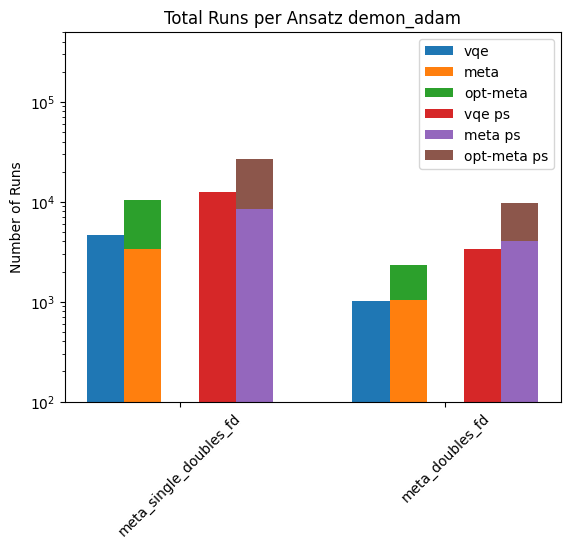

In [9]:
opt_runs = optimizers[3]

fig, ax = plt.subplots()

vqe_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_fd)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][1]*overheads_fd[count]*5*4 for count,idx in enumerate(index_per_runs_plot_fd)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][2]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_fd)]

vqe_data_ps = [condensed_data[idx][opt_runs]["runs"][0]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs_ps = [condensed_data[idx][opt_runs]["runs"][1]*overheads_ps[count]*5*4 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data_ps = [condensed_data[idx][opt_runs]["runs"][2]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]



ind = np.arange(len(vqe_data)) 

width = 0.14                    # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(2*width))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_data)), vqe_data, width=width, label = "vqe")
plt.bar(np.arange(len(meta_runs))+ width, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")

plt.bar(np.arange(len(vqe_data_ps))+ width*3, vqe_data_ps, width=width, label="vqe ps")
plt.bar(np.arange(len(meta_runs_ps))+ width*4, meta_runs_ps, width=width, label="meta ps")
plt.bar(np.arange(len(opt_meta_data_ps))+ width*4, opt_meta_data_ps, width=width, bottom= meta_runs_ps, label="opt-meta ps")
ax.legend()
plt.yscale('log')
plt.ylim(100, 500000)
plt.show()

[525.0, 252.0]


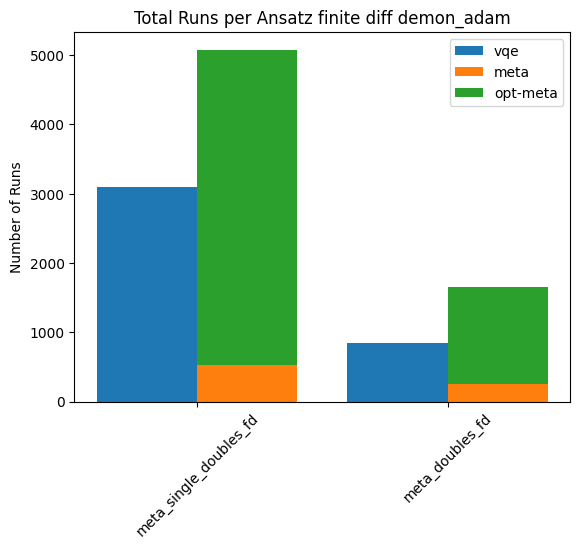

In [10]:
opt_runs = optimizers[3]

fig, ax = plt.subplots()

vqe_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][1]*overheads_fd[count]*5 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][2]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_ps)]


print(meta_runs)


ind = np.arange(len(vqe_data)) 

width = 0.4                      # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz finite diff {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(width/2))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_data)), vqe_data, width=width, label = "vqe")
plt.bar(np.arange(len(meta_runs))+ width, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")
ax.legend()
plt.show()